# Project: Decision Trees

## Machine Learning, Winter 2017

### Name: Nicholas Miklaucic


In this project, you'll perform the following tasks:
1. Construct a (Python) class `DecisionTree` which will serve as our first machine learning model.
2. Test it out on multiple datasets.  If you've done the above correctly, this shouldn't be hard!
3. Determine the effects of overfitting and attempt some solutions, discussing which seem to work best.

In [9]:
# Standard import statements:
from itertools import combinations, chain
from statistics import mean, median

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, r2_score

%matplotlib inline

plt.style.use("ggplot")

In [25]:
df = pd.read_csv("noisy_dataset.csv", index_col=0)
df.head()

,x_1,x_2,y
0,0.169124,6.545124,0.0
1,1.244786,7.681310,0.0
2,0.926550,5.063571,0.0
3,6.298943,7.374926,0.0
4,4.479117,8.684585,0.0


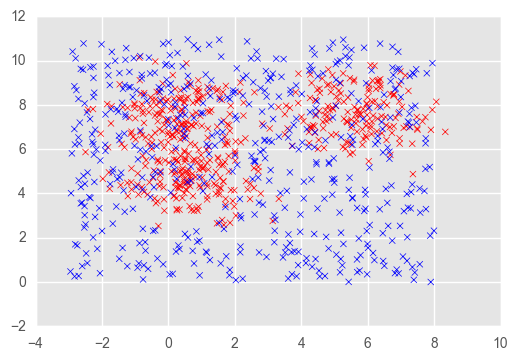

In [27]:
c = ['rb'[int(i)] for i in df["y"]]
plt.scatter(df["x_1"], df["x_2"], marker='x', c=c)

## `DecisionTree` Class

Construct a `DecisionTree` class in the cell below.  It should support the standard scikit-learn API: 

```
>>> X, y = <your_dataset>
>>> model = DecisionTree() # potentially with some parameters, if needed
>>> model.fit(X,y)
>>> model.predict(<new_sample_vector>)
1
>>> # If the model predicted your sample vector to be in class 1.
```

Note that your `predict` function should support either single predictions or multiple predictions, though you can force the user to do single predictions as a 2d array (single-row "multiple" predictions) so you only have one implementation to write.  What I mean by this is `model.predict(X)` should work (without error) to create all predictions for `y`.

You should construct some human-readable visualization of your model, simply from a printout.  This way you can tell if the model is being built the way you want.  The best way to do this is to implement the `__str__` method for your class.  Probably the easiest way to do this is to iterate through the tree in a "depth-first" fashion, and for each node, just print out some basic facts, like the number of elements in that node, or the indices of those elements in `X`, and the class assignment if it's a leaf node; also, make sure the indentation level of each node increases as its depth increases.  It might be helpful to have your nodes be more than just the bare minimum object (which would probably be a list of the indices of the rows in `X` for the items in your node).  To reiterate: this should NOT be a "beautiful" printout with lines like:
```
            root
           /    \
     child1      child2 
    /      \    /      \
...
```

Because that would get awkward fast.  What I'm imagining is:

```
root: <root_info>
  child1: <child1_info>
    grandchild1: <grandchild1_info>
      ...
    grandchild1: <grandchild2_info>
      ...
  child2: <child2_info>
    grandchild1: <grandchild1_info>
    grandchild1: <grandchild2_info>
```

By implementing this in `__str__` for your class, this will be the printout when you run:

```
model = DecisionTree(<whatever_you_need_to_do_to_create_your_model>)
model.fit(X,y)
print(model)
```

Recall the algorithm for fitting a decision tree:
1. Start with all your data samples in a single node.
2. For a given node, determine if you want to split at that node or not.  For now, this should just be a check to see if the node is "pure", meaning it only contains one class.  If you do decide to split it further, compute all possible splits of your data (all possible depth-1 subtrees).  For categorical variables, this should look like generating all pairs of combinations of classes.  For continuous or ordinal variables, sort the entries in that column, and then all possible splits involve cutting off at values between adjacent entries.  That is, if the entries in my continuous column are `[2.01, 3.425, 8.67, 493.6]`, then I have three splits, which are 
"$x_i\leq 2.01$", "$x_i\leq 3.425$", "$x_i\leq 8.67$".
3. Compute the change in Gini Impurity for each split, and choose the split that has the largest gain in information (most pure nodes).  Recall that the Gini Impurity for a node is 
$$ I = 1 - \sum_{\text{each class}} \left(\frac{\text{# of elements in that class}}{\text{# of elements in the node}}\right)^2$$
So then you want to maximize $I_\text{new_child1} + I_\text{new_child2} - I_\text{old}$; that is, choose the split with the largest value for that quantity (roughly interpretted as "information gain", though for the record the term "information gain" is used in a totally-synonymous-but-technically-different situation).
4. Repeat until all nodes are pure.
5. (Get the above working first, and then later:) prune the tree back to avoid overfitting your training data. (See below)

Note that your (Python) class should work for multi-class datasets (where you're trying to predict a `y` that has more than two classes).

In [2]:
# your class code here

To test out your code, here's a simple dataset.  You could check it by hand if you need to debug.  You're trying to predict whether an animal is a mammal or not (the class label).

In [45]:
X = [["human", "warm-blooded", "yes", "no", "no", "yes"],
     ["pigeon", "warm-blooded", "no", "no", "no", "no"],
     ["elephant", "warm-blooded", "yes", "yes", "no", "yes"],
     ["leopard shark", "cold-blooded", "yes", "no", "no", "no"],
     ["turtle", "cold-blooded", "no", "yes", "no", "no"],
     ["penguin", "cold-blooded", "no", "no", "no", "no"],
     ["eel", "cold-blooded", "no", "no", "no", "no"],
     ["dolphin", "warm-blooded", "yes", "no", "no", "yes"],
     ["spiny anteater", "warm-blooded", "no", "yes", "yes", "yes"],
     ["gila monster", "cold-blooded", "no", "yes", "yes", "no"]]

df = pd.DataFrame(X, columns = ["Name", 
                                "Body Temperature", 
                                "Gives Birth", 
                                "Four-legged", 
                                "Hibernates", 
                                "Class Label"])

## Try it out on multiple datasets

Feel free to split these amongst your group mates, then consolodate it into one notebook.

1. The dataset `X` above.

2. To double check that your multi-class support is working, use the [iris dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris).  Plot some decision boundaries of the classifier you make in all the pairs of dimensions in your scatter plots.

3. Take a look at some of the [dataset constructors in scikit-learn](http://scikit-learn.org/stable/datasets/#sample-generators).  Pick one that will allow you to generate a dataset that has $\geq 4$ features, and multiple classes ($\geq 3$); but also make sure that when I run your code with some tweaked numbers from these, it will still work.

4. Kaggle is a website which offers machine learning challenges to anyone with an interest in working on them, some of which have real prizes associated with them.  The [Titanic challenge](https://www.kaggle.com/c/titanic/data) is a tutorial challenge which has you attempting to predict whether someone did or did not die on board the Titanic, based on their criteria.  In order to download the dataset, you'll need to make an account, and agree to some scary-sounding agreement about not sharing their data with the world (to make their legal team happy).  Do only the minimum of data cleanup on it, trash the name column (unless you want to get really fancy), and fit a decision tree to the dataset.  Make sure to save some data for testing purposes.

5. Add some classification metrics to your above models, like the `accuracy_score` and `confusion_matrix`.  Add additionally [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), and explain what those are.

6. For the dataset `noisy_dataset.csv`, available on Canvas in `Files`, plit the data into `test` and `train` sets, and then construct a family of decision trees with an increasing number of nodes, say from 3 up to something large (large enough that the test accuracy starts getting awful). Plot a pair of curves on the same axes: (# of nodes) vs. model accuracy (training and test).  Discuss which models make the best predictors.

In [105]:
# your code here

## Compare to scikit-learn's `DecisionTreeClassifier` class

It should come as no surprise to you that scikit-learn has a [decision tree class](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier).  Compare your constructed class to theirs in terms of their functionality, what attributes and constructor-arguments does their decision tree class have that yours does not?

[Your response here]

## Overfitting and what to do about it

What we saw (hopefully!) in dataset 6 above is called __overfitting__, meaning our model is learning the noise in the training data.  This weakens the models predictive power.  There are many options to reduce overfitting, here are a few.  Implement at least one of them, until you have something that makes your models noticeably better.

* Add a stopping condition: 
 * stop splitting off more nodes when a node reaches either a minimal number of items per node _or_ is a pure node,
 * stop splitting by not allowing any child nodes to go below a minimum number of nodes,
 * stop splitting when you've reached some maximum depth.
* After fitting a deep, overfit tree, use a __validation__ set to _prune_ the tree: remove nodes by rejoining children into parents, then test them against the validation set to see if the pruned tree was better.  Do this until you stop seeing improvements on the validation set.  Here a validation set means a third split of data, different from test and train.  It's different from the training set because you're not training the model on it, but it's also not testing data because you're changing your model based on knowledge gained from the dataset.  It's somewhere in between.  Feel free to ask me about _cross-validation_ as well, and how you could use that instead.  We'll talk about it eventually, but I don't want to add more to this project than is already here.

__Explain to me what you did, and where it shows up in your code (for example, is it in your class definition?).__

## Possible extensions

Here are two extensions of the `DecisionTree` class that you made.  They are entirely optional, so don't feel you need to do them!

* In reality, people use decision trees on a limited basis, typically only when model interpretability is forced by government institutions (so, this happens a lot with banks, for example).  What you normally do is build a __forest__ of trees, that is, a collection of several trees (a common number is 50-500 trees), and then have them vote.  However, if you let your trees build themselves from the same exact datasets each time, they will be roughly the same, and the power of this voting model will be irrelevant.  Thus, one extremely common model is called the __Random Forest__ classifier: give each tree only a subset of the features to train from, don't prune at all (allow them to overfit on that subset), and then have them vote.  This increases the variance of the distribution of tree votes, which helps to average out the errors.  Create a new Python class that builds this classification model.  Note that Random Forests are a current industry favorite (among other things, like support vector machines, boosted trees, and neural networks), meaning if you do this you'll have created a model capable of hacking it with some of the best!

* Scikit-learn's `DecisionTreeClassifier` has a somewhat pretty visualization of the tree that can be exported using the library `GraphViz`.  There are python wrappers to this module, the most common is `pydot`.  Using these libraries, or similar ones, add the functionality of constructing an attractive visualization of your decision tree class.

## Reference

The following is reference code for you, and should be deleted from your final submission.

In [ ]:
####### Decision boundary plotting #######

df = None                          ## Set this!
x_axis_name = "first predictor"    ## Set this!
y_axis_name = "second predictor"   ## Set this!
model = my_decision_tree_model     ## Set this!

# CONSTANTS
GRANULARITY = 50

#### CREATE PREDICTION SURFACE ####
x1_min, x1_max, x2_min, x2_max = (df[x_axis_name].min(),
                                  df[x_axis_name].max(),
                                  df[y_axis_name].min(),
                                  df[y_axis_name].max())

xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, GRANULARITY),
                       np.linspace(x2_min, x2_max, GRANULARITY))

xx1_col = xx1.ravel() 
xx2_col = xx2.ravel()

# In order to make predictions, you may need to add some amount of columns of medians
# xx3_col = np.zeros(xx1_col.shape) + df.median('x_3')

X_columns_1 = np.c_[xx1_col, xx2_col] #, xx3_col]                                        ## Set this!

yy_1 = model.predict(X_columns_1).T[0]

#### PLOTTING ####
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.xlabel('Set x-axis label')
plt.ylabel('Set y-axis label')
plt.title('Set title')

plt.contour(xx1, xx2, yy_1, levels=[.5], colors=['c'])
plt.scatter(df[x_axis_name],df[y_axis_name])                                        ## Set this!  Need c=

plt.show()

In [110]:
class Tree(object):
    def __init__(self, x=None):
        # This is your constructor; it sets attributes ("fields")
        self.x = x
        
    def __repr__(self):
        # This is what comes out when you return the object to standard display (not print)
        return "Tree(x = {})".format(repr(self.x))
    
    def __str__(self):
        # This is what comes out when you print.
        return "Tree with x = {}".format(self.x.__repr__())

    def __eq__(self, that): 
        # This is how you determine how objects of type Tree compare with `==`
        return type(that) == type(self) and self.x == that.x 

In [112]:
t = Tree(7)
s = Tree({45:'yes', 86:'no'})
l = Tree()

# It's often a good idea to (if possible) define `__repr__` such that the following assert passes:
assert eval(repr(t)) == t

In [113]:
# `__repr__` determines what happens when when you just return the object to stdout:
t

Tree(x = 7)

In [124]:
# `__str__` determines what happens when you print the object:
print(t)
print(s, l, sep='\t and \t')

Tree with x = 7
Tree with x = {45: 'yes', 86: 'no'}	 and 	Tree with x = None


#### How I generated `noisy_dataset.csv`.
It won't give you the same thing, because I didn't set a seed.

In [48]:
from sklearn.datasets import make_blobs

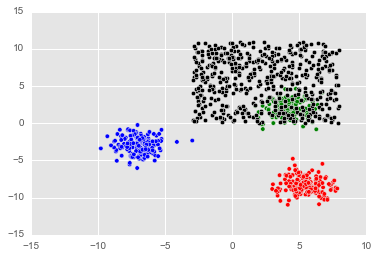

In [120]:
X, y = make_blobs(n_samples= 500)
X2 =11 * np.random.rand(500,2) - (3,0)
df = pd.DataFrame(np.concatenate([X,X2]))
df.columns = ['x_1', 'x_2']
df['y'] = np.concatenate((np.zeros(500), np.zeros(500)+1))

colors = {0:'r',1:'b',2:'g'}

plt.scatter(X.T[0],X.T[1], c=[colors[i] for i in y])
plt.scatter(X3.T[0], X3.T[1], c='k')
plt.show()